In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from pathlib import Path
from scipy import stats
import joblib
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier

from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, precision_score,recall_score

import optuna
import mlflow
import mlflow.tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

import warnings
warnings.filterwarnings('ignore')


### ** Top 5  Models **

| Rank | Model | Mean Accuracy | Macro F1-Score | Recall (Class 1) |
|:---|:---|:---|:---|:---|
| 1 | **Random Forest Classicifac** | 91.12% | 0.88 | 0.70 |
| 2 | **Gradient Boosting Regression** | 90.96% | 0.87 | 0.70 |
| 3 | **XG Boost** | 90.80% | 0.87 |0.70 |
| 4 | **Ada Boost** | 89.94% | 0.86 | 0.71 |
| 5 | **Neural Network** | 89.91% | 0.86 | 0.68 |

In [3]:
train_original = pd.read_csv(r'C:\Users\user\Desktop\ML & DL projects\2 Stage loan system\data\feature_engineered\train_classification_data.csv')
test_original = pd.read_csv(r'C:\Users\user\Desktop\ML & DL projects\2 Stage loan system\data\feature_engineered\test_classification_data.csv')

In [4]:
# train set
X_train = train_original.drop(columns='loan_approval', axis = 1)
y_train = train_original['loan_approval']

# test set
X_test = test_original.drop(columns='loan_approval', axis = 1)
y_test = test_original['loan_approval']

In [5]:
# for neural networks

def ann(trial):
    # 1. Define the Hyperparameter Search Space
    n_layers = trial.suggest_int('n_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Start MLflow run for this specific trial
    with mlflow.start_run(nested=True):
        # 2. Build the Model Dynamically
        model = Sequential()
        model.add(Dense(trial.suggest_int('units_input', 64, 256), 
                        input_shape=(X_train.shape[1],), activation='relu'))
        
        for i in range(n_layers):
            model.add(Dense(trial.suggest_int(f'units_layer_{i}', 16, 128), activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(dropout_rate))
            
        model.add(Dense(1, activation='sigmoid'))

        # 3. Compile
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # 4. Train
        early_stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=batch_size,
            callbacks=[early_stopper],
            verbose=0  # Keep it quiet during optimization
        )

        # 5. Log to MLflow
        val_accuracy = max(history.history['val_accuracy'])
        mlflow.log_params(trial.params)
        mlflow.log_metric("max_val_accuracy", val_accuracy)
        
        return val_accuracy

# --- Running the Optimization ---
mlflow.set_experiment("ANN_Loan_Optimization")

study = optuna.create_study(direction='maximize')
study.optimize(ann, n_trials=20)

print(f"Best Trial: {study.best_trial.params}")

2026/02/02 00:46:34 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/02 00:46:34 INFO mlflow.store.db.utils: Updating database tables
2026/02/02 00:46:34 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/02 00:46:34 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/02 00:46:34 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/02 00:46:34 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/02/02 00:46:34 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/02/02 00:46:34 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/02/02 00:46:34 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/02/02 00:46:34 INFO alembic.runtime.migration: Running 

Best Trial: {'n_layers': 3, 'dropout': 0.11713860682509294, 'learning_rate': 0.008773502747449457, 'batch_size': 32, 'units_input': 64, 'units_layer_0': 104, 'units_layer_1': 125, 'units_layer_2': 20}


In [6]:
# for ANN, retrieving the best parameters and training the model

# 1. Extract best parameters from your Optuna study
best_params = study.best_params

# 2. Rebuild the model using the winning architecture
best_ann_model = Sequential()

# Input Layer + First Hidden Layer (units_input from Optuna)
best_ann_model.add(Dense(best_params['units_input'], input_shape=(X_train.shape[1],), activation='relu'))
best_ann_model.add(BatchNormalization())
best_ann_model.add(Dropout(best_params['dropout']))

# Adding the dynamic hidden layers found by Optuna
for i in range(best_params['n_layers']):
    layer_units = best_params[f'units_layer_{i}']
    best_ann_model.add(Dense(layer_units, activation='relu'))
    best_ann_model.add(BatchNormalization())
    best_ann_model.add(Dropout(best_params['dropout']))

# Output Layer
best_ann_model.add(Dense(1, activation='sigmoid'))

# 3. Compile with the optimized learning rate
best_ann_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Train with the optimized batch size
early_stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = best_ann_model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=best_params['batch_size'], 
    validation_split=0.2,
    callbacks=[early_stopper],
    verbose=1
)

Epoch 1/200
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8174 - loss: 0.4417 - val_accuracy: 0.8410 - val_loss: 0.3960
Epoch 2/200
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8449 - loss: 0.3992 - val_accuracy: 0.8732 - val_loss: 0.3639
Epoch 3/200
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8531 - loss: 0.3847 - val_accuracy: 0.8596 - val_loss: 0.3652
Epoch 4/200
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8655 - loss: 0.3704 - val_accuracy: 0.8749 - val_loss: 0.3608
Epoch 5/200
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8671 - loss: 0.3691 - val_accuracy: 0.8656 - val_loss: 0.3644
Epoch 6/200
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8704 - loss: 0.3646 - val_accuracy: 0.8823 - val_loss: 0.3480
Epoch 7/200
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8720 - loss: 0.3627 - val_accuracy: 0.8928 - val_loss: 0.3381
Epoch 8/200
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8761 - loss: 0.3553 - val_accu

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
Final Optimized ANN Test Accuracy: 0.9019

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.89      0.98      0.94      3827
           1       0.94      0.67      0.78      1384

    accuracy                           0.90      5211
   macro avg       0.92      0.83      0.86      5211
weighted avg       0.91      0.90      0.90      5211



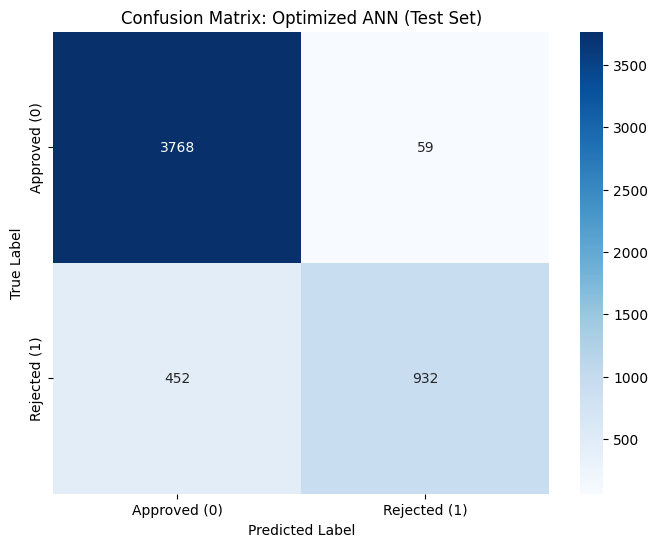

In [7]:
# classification report and confusion matrix 

# 1. Generate predictions on the UNSEEN test data
y_pred_probs = best_ann_model.predict(X_test) 

# 2. Convert probabilities to binary classes
y_pred = (y_pred_probs > 0.5).astype(int)

# 3. Print the Accuracy Score for the test set
print(f"Final Optimized ANN Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# 4. Generate the Classification Report
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred))

# 5. Visualize the Confusion Matrix for the test set
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Approved (0)', 'Rejected (1)'], 
            yticklabels=['Approved (0)', 'Rejected (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Optimized ANN (Test Set)')
plt.show()


In [9]:
# optuna and mlflow for top 4 ml models

def objective(trial):
    # 1. Select the model type from your Top 5 list
    model_type = trial.suggest_categorical("model_type", 
                                          ["RandomForest", "GradientBoosting", "XGBoost", "AdaBoost"])
    
    with mlflow.start_run(nested=True):
        mlflow.log_param("model_type", model_type)
        
        if model_type == "RandomForest":
            params = {
                "n_estimators": trial.suggest_int("rf_n_estimators", 100, 1000),
                "max_depth": trial.suggest_int("rf_max_depth", 10, 50),
                "min_samples_split": trial.suggest_int("rf_split", 2, 10),
                "max_features": trial.suggest_categorical("rf_feat", ["sqrt", "log2"]),
                "random_state": 42,
                "n_jobs": -1
            }
            model = RandomForestClassifier(**params)

        elif model_type == "GradientBoosting":
            params = {
                "n_estimators": trial.suggest_int("gb_n_estimators", 100, 1000),
                "learning_rate": trial.suggest_float("gb_lr", 0.01, 0.2, log=True),
                "max_depth": trial.suggest_int("gb_max_depth", 3, 10),
                "subsample": trial.suggest_float("gb_subsample", 0.7, 1.0),
                "random_state": 42
            }
            model = GradientBoostingClassifier(**params)

        elif model_type == "XGBoost":
            params = {
                "n_estimators": trial.suggest_int("xgb_n_estimators", 100, 1000),
                "max_depth": trial.suggest_int("xgb_max_depth", 3, 10),
                "learning_rate": trial.suggest_float("xgb_lr", 0.01, 0.2, log=True),
                "gamma": trial.suggest_float("xgb_gamma", 1e-3, 1.0, log=True),
                "random_state": 42,
                "eval_metric": "logloss"
            }
            model = xgb.XGBClassifier(**params)

        elif model_type == "AdaBoost":
            params = {
                "n_estimators": trial.suggest_int("ada_n_estimators", 50, 500),
                "learning_rate": trial.suggest_float("ada_lr", 0.01, 1.0, log=True),
                "random_state": 42
            }
            model = AdaBoostClassifier(**params)

        # 2. Train and Predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # 3. Calculate Classification Metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        recall_class1 = recall_score(y_test, y_pred) # Recall for 'Rejected' class

        # 4. Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metrics({
            "accuracy": accuracy,
            "f1_macro": f1_macro,
            "recall_risk": recall_class1
        })

        # We return f1_macro because it balances both classes better than accuracy
        return f1_macro 

In [10]:
# 1. Set the tracking URI to your specific project folder
# Using raw string (r"") to handle backslashes correctly
mlflow.set_tracking_uri(r"file:///C:\Users\user\Desktop\ML & DL projects\2 Stage loan system\mlruns")

# 2. Set the experiment name
mlflow.set_experiment("top_4_models_classification_optimization")

# 3. Create and run the study
# IMPORTANT: Change to 'maximize' because we are returning F1-Score (higher is better)
study = optuna.create_study(direction="maximize")

# Start a Parent Run to group all 30 trials together
with mlflow.start_run(run_name="Hyperparameter_Sweep_Top4"):
    mlflow.log_param("n_trials", 30)
    
    # Run the optimization
    study.optimize(objective, n_trials=30) 

    # 4. Log the BEST results back to the Parent Run for easy viewing
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_f1_macro", study.best_value)
    
    # Tag the run for better filtering in the UI
    mlflow.set_tag("stage", "model_selection")
    mlflow.set_tag("priority_metric", "F1-Macro")

# 5. Results Interpretation (Console Output)
print("="*35)
print("   OPTIMIZATION COMPLETE    ")
print("="*35)
print(f"Best Model Type:   {study.best_params['model_type']}")
print(f"Best F1-Macro:     {study.best_value:.4f}")
print("-" * 35)
print("Best Hyperparameters Found:")
for key, value in study.best_params.items():
    # Only print hyperparameters, skip the 'model_type' tag
    if key != "model_type":
        print(f"  {key}: {value}")
print("="*35)

2026/02/02 01:19:40 INFO mlflow.tracking.fluent: Experiment with name 'top_4_models_classification_optimization' does not exist. Creating a new experiment.
[I 2026-02-02 01:19:40,418] A new study created in memory with name: no-name-5ce1e3c3-968f-4228-a336-1e4a51db9198
[I 2026-02-02 01:19:53,071] Trial 0 finished with value: 0.8747482800035142 and parameters: {'model_type': 'GradientBoosting', 'gb_n_estimators': 552, 'gb_lr': 0.04538848036601786, 'gb_max_depth': 3, 'gb_subsample': 0.744542558220555}. Best is trial 0 with value: 0.8747482800035142.
[I 2026-02-02 01:19:57,499] Trial 1 finished with value: 0.8746004645732248 and parameters: {'model_type': 'GradientBoosting', 'gb_n_estimators': 117, 'gb_lr': 0.05064460885835328, 'gb_max_depth': 4, 'gb_subsample': 0.9491754492336487}. Best is trial 0 with value: 0.8747482800035142.
[I 2026-02-02 01:20:29,944] Trial 2 finished with value: 0.8715561112527856 and parameters: {'model_type': 'GradientBoosting', 'gb_n_estimators': 538, 'gb_lr': 0

   OPTIMIZATION COMPLETE    
Best Model Type:   RandomForest
Best F1-Macro:     0.8752
-----------------------------------
Best Hyperparameters Found:
  rf_n_estimators: 823
  rf_max_depth: 50
  rf_split: 4
  rf_feat: log2


In [11]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix
import joblib

# 1. Retrieve best parameters
best_params = study.best_params.copy()
model_type = best_params.pop("model_type")

# 2. Dynamic Initialization with Name Mapping
match model_type:
    case "GradientBoosting":
        mapping = {"gb_lr": "learning_rate", "gb_n_estimators": "n_estimators", 
                   "gb_max_depth": "max_depth", "gb_subsample": "subsample"}
        clean_params = {mapping.get(k, k): v for k, v in best_params.items()}
        best_model = GradientBoostingClassifier(**clean_params, random_state=42)
        
    case "RandomForest":
        mapping = {"rf_n_estimators": "n_estimators", "rf_max_depth": "max_depth", 
                   "rf_split": "min_samples_split", "rf_feat": "max_features"}
        clean_params = {mapping.get(k, k): v for k, v in best_params.items()}
        best_model = RandomForestClassifier(**clean_params, n_jobs=-1, random_state=42)
        
    case "XGBoost":
        mapping = {"xgb_lr": "learning_rate", "xgb_n_estimators": "n_estimators", 
                   "xgb_max_depth": "max_depth", "xgb_gamma": "gamma"}
        clean_params = {mapping.get(k, k): v for k, v in best_params.items()}
        best_model = xgb.XGBClassifier(**clean_params, random_state=42, eval_metric="logloss")
        
    case "AdaBoost":
        mapping = {"ada_lr": "learning_rate", "ada_n_estimators": "n_estimators"}
        clean_params = {mapping.get(k, k): v for k, v in best_params.items()}
        best_model = AdaBoostClassifier(**clean_params, random_state=42)
        
    case _:
        raise ValueError(f"Unknown model type: {model_type}")

# 3. Train the model
print(f"Training the final {model_type} model with best hyperparameters...")
best_model.fit(X_train, y_train)

# 4. Evaluate on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
recall_risk = recall_score(y_test, y_pred) # Recall for class 1 (Rejections)

print(f"\nFinal Tuned {model_type} Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"Recall (Risk Detection): {recall_risk:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 5. Log the final run to MLflow
with mlflow.start_run(run_name=f"final_best_{model_type.lower()}"):
    mlflow.log_params(clean_params)
    mlflow.log_metrics({
        "accuracy": accuracy, 
        "f1_macro": f1_macro, 
        "recall_risk": recall_risk
    })
    
    # Log the model based on its library
    if model_type == "XGBoost":
        mlflow.xgboost.log_model(best_model, artifact_path="model")
    else:
        mlflow.sklearn.log_model(best_model, artifact_path="model")

Training the final RandomForest model with best hyperparameters...


2026/02/02 01:28:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Final Tuned RandomForest Performance:
Accuracy: 0.9121
F1 Macro: 0.8752
Recall (Risk Detection): 0.6936

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3827
           1       0.97      0.69      0.81      1384

    accuracy                           0.91      5211
   macro avg       0.93      0.84      0.88      5211
weighted avg       0.92      0.91      0.91      5211



Final Optimized RandomForest model with best hyperparameters Test Accuracy: 0.9121

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3827
           1       0.97      0.69      0.81      1384

    accuracy                           0.91      5211
   macro avg       0.93      0.84      0.88      5211
weighted avg       0.92      0.91      0.91      5211



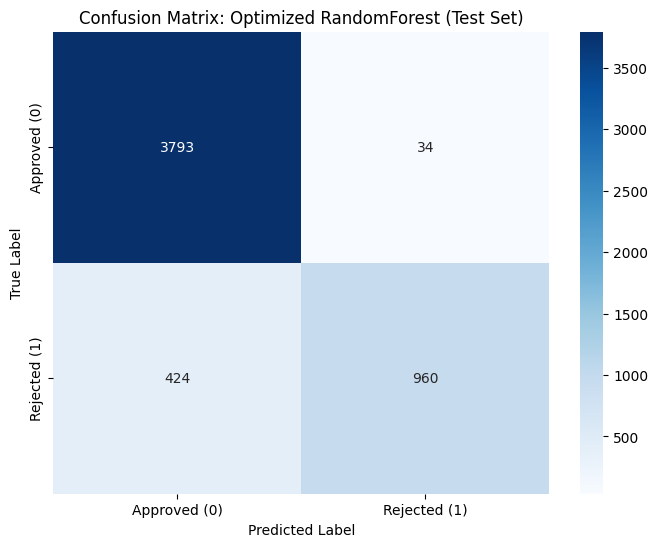

In [14]:
y_pred_probs = best_model.predict(X_test) 

# 2. Convert probabilities to binary classes
#y_pred = (y_pred_probs > 0.5).astype(int)

# 3. Print the Accuracy Score for the test set
print(f"Final Optimized RandomForest model with best hyperparameters Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# 4. Generate the Classification Report
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred))

# 5. Visualize the Confusion Matrix for the test set
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Approved (0)', 'Rejected (1)'], 
            yticklabels=['Approved (0)', 'Rejected (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Optimized RandomForest (Test Set)')
plt.show()


In [15]:
# 6. Save locally as well
joblib.dump(best_model, f'best_{model_type.lower()}_optimized.pkl')
print(f"Model saved locally as best_{model_type.lower()}_model.pkl")

Model saved locally as best_randomforest_model.pkl
